In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

import numpy as np
import pandas as pd

import json
from tqdm.notebook import tqdm

In [2]:
model = torch.load('cxr8_w_cl_map_129eps.pt')
model.eval()

MyResNet(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [3]:
# getting output from transition layer
return_nodes = {
    "transition": "transition"
}
model2 = create_feature_extractor(model, return_nodes=return_nodes)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
%cd mimic_pa

/data/iasviridov/work/chest/detr_work/mimic/mimic_pa


In [6]:
df_train = pd.read_csv("mimic_train.csv")
df_val = pd.read_csv("mimic_val.csv")
df_test = pd.read_csv("mimic_test.csv")

In [7]:
%cd ..

/data/iasviridov/work/chest/detr_work/mimic


In [8]:
with open('mimic_id2label.json', 'r') as fp:
    id2label = json.load(fp)
id2label

{'0': 'Atelectasis',
 '1': 'Cardiomegaly',
 '2': 'Consolidation',
 '3': 'Edema',
 '4': 'Enlarged Cardiomediastinum',
 '5': 'Fracture',
 '6': 'Lung Lesion',
 '7': 'Lung Opacity',
 '8': 'Pleural Effusion',
 '9': 'Pleural Other',
 '10': 'Pneumonia',
 '11': 'Pneumothorax'}

In [9]:
class MimicDataset(Dataset):
    
    def __init__(self, main_root='/data/iasviridov/work/chest/detr_work/mimic/mimic_pa/', 
                 mode="train", transform=None):
        
        self.train = True if mode == "train" else False
        self.transform = transform
        self.root = main_root
        self.data = pd.read_csv(self.root + 'mimic_train.csv' if self.train else self.root + 'mimic_val.csv')
        
    def __len__(self):
        # return dataset length
        return len(self.data)
    
    def __getitem__(self, index):
        # load image
        try:
            sample = cv2.imread(self.root + self.data.loc[index, 'dicom_id'] + '.jpg')
            sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        except:
            print('filename ', self.root + self.data.loc[index, 'dicom_id'] + '.jpg, ', index)
            print()
        
        # transform image
        sample = self.transform(sample)
        # normalization
        sample = sample.float() / 255
        # return dict with image and class label
        label = self.data.loc[index, self.data.columns[3:-1]].values.astype(None)

        return {
            "image": sample,
            "label": label, # int label
        }

In [10]:
class Transform:
    def __init__(
        self, hflip_prob: float = 0.4, ssr_prob: float = 0.4, random_bc_prob: float = 0.4, image_size = 32
    ):
        self.transform = A.Compose(
            [
                A.HorizontalFlip(p=hflip_prob),
                
                A.ShiftScaleRotate(
                    shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=ssr_prob),
                
                A.RandomBrightnessContrast(p=random_bc_prob),
                
                A.Resize(height=image_size, width=image_size),
                
                A.pytorch.ToTensorV2()
            ]
        )

    def __call__(self, image):
        image = self.transform(image=image)["image"]
        return image

In [11]:
train_mimic = MimicDataset(mode="train", transform=Transform())
val_mimic = MimicDataset(mode="val", transform=Transform())

In [14]:
train_loader = DataLoader(train_mimic, shuffle=True, pin_memory=True, batch_size=1)

In [27]:
result = []
classes = []

k = 0
for batch in tqdm(train_loader):

    batch = {k: v.to(device) for k, v in batch.items()}

    x = batch['image']
    y = batch['label']

    intermediate_outputs = model2(x)
    result.append(intermediate_outputs['transition'].permute(0, 2, 3, 1) @ torch.transpose(model.prediction.weight, 0, 1))
    classes.append(y)
    k +=1
    if k == 9:
        break

  0%|          | 0/68495 [00:00<?, ?it/s]

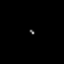

In [38]:
img = Image.fromarray(np.uint8(result[5].cpu().detach().numpy().squeeze(axis=0).transpose(2,0,1)[0] * 255) , 'L').resize((64,64))
display(img)

In [37]:
classes[5]

tensor([[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]], device='cuda:0',
       dtype=torch.float64)